### **Análise de regressão**

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sms
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('mode.chained_assignment', None)
sns.set(style='whitegrid')

In [2]:
pnad1 = pd.read_csv('dados/pnad.csv') # pnadc 2tri 2017
pnad2 = pnad1.query('idade > 17')  # incluir apenas quem já poderia ter concluído o ensino médio
pnad3 = pnad2.query('freq_esc == 2')
pnad4 = pnad3.query('nivel_instrucao == [3, 5]')
linha_vazia = pd.DataFrame([np.nan]).T
pnad_zero = pnad4
pnad_zero.rendimento = pnad_zero.rendimento.fillna(0) # trabalhadores familiares auxiliares, quem recebe em espeécie, 
                                                      # desocupados, donas de casa, nem nem
pnad = pnad4.query('rendimento > 0')
pnad = pnad.assign(rendimento_log=np.log(pnad.rendimento))

print(' início: ', pnad1.shape[0], '\n',
      'idade > 17: ', pnad2.shape[0], '\n',
      'não freqenta a escola: ', pnad3.shape[0], '\n',
      'fundamental ou médio: ', pnad4.shape[0], '\n',
      'rendimento > 0: ', pnad.shape[0])

 início:  568313 
 idade > 17:  417664 
 não freqenta a escola:  382971 
 fundamental ou médio:  139179 
 rendimento > 0:  85122


In [3]:
df = pnad1.query('idade > 25').nivel_instrucao.value_counts() / pnad1.query('idade > 25').shape[0]

In [4]:
df[[1, 2, 3, 4]].sum()

0.5989869557558413

In [5]:
pnad.groupby('nivel_instrucao').rendimento.describe(percentiles=[.9, .95, .99])

,count,mean,std,min,50%,90%,95%,99%,max
nivel_instrucao,,,,,,,,,
3.0,18459.0,1389.439135,1832.573276,10.0,1100.0,2500.0,3000.0,6000.0,166666.0
5.0,66663.0,1595.003810,1657.389486,4.0,1200.0,3000.0,4000.0,7000.0,100000.0


Para facilitar a visualização, foram retiradas as observações com valores mais altos (1% do ensino médio).

In [6]:
ocup_forca = pd.crosstab(pnad_zero.ocup_forca, pnad_zero.nivel_instrucao, normalize='columns').round(2) * 100
ocup_forca.index = ['sim', 'não']
ocup_forca = pd.concat([linha_vazia, ocup_forca])

rendimento = (pnad_zero.groupby('nivel_instrucao').rendimento.describe(percentiles=[.5]).astype(int).T.iloc[1:, :])
rendimento.index = ['média', 'desvio padrão', 'mínimo', 'mediana', 'máximo']

idade = pnad_zero.groupby('nivel_instrucao').idade.describe(percentiles=[.5]).round(1).T.iloc[1:, :]
idade.index = ['média', 'desvio padrão', 'mínimo', 'mediana', 'máximo']
idade = pd.concat([linha_vazia, idade])

sexo = pd.crosstab(pnad_zero.sexo, pnad_zero.nivel_instrucao, normalize='columns').round(2) * 100
sexo.index = ['masculino', 'feminino']
sexo = pd.concat([linha_vazia, sexo])

ocup_pos2 = pd.crosstab(pnad_zero.ocup_pos2, pnad_zero.nivel_instrucao, normalize='columns').round(4) * 100
ocup_pos2.index = ['empregado s. priv. c/ cart.', 'empregado s. priv. s/ cart.', 'trabalhador domest. c/ cart.', 'trabalhadores domest. s/ cart.',
                   'empregado s. pub. c/ cart.', 'empregado s. pub. s/ cart.', 'militar e servidor estatutário', 'empregador', 
                   'trabalhador por conta própria', 'trabalhador familiar auxiliar']
ocup_pos2 = pd.concat([linha_vazia, ocup_pos2])

resumo1 = (pd.concat([sexo, ocup_forca, ocup_pos2, idade, rendimento], 
                    keys=['Sexo', 'Força de trabalho', 'Posição na ocupação', 'Idade', 'Rendimento'])
                   .drop(0, axis=1))
resumo1.columns = ['Ensino fundamental', 'Ensino médio']
resumo1

Ensino fundamental  \
Sexo                0                                              NaN   
                    masculino                                    50.00   
                    feminino                                     50.00   
Força de trabalho   0                                              NaN   
                    sim                                          66.00   
                    não                                          34.00   
Posição na ocupação 0                                              NaN   
                    empregado s. priv. c/ cart.                  32.41   
                    empregado s. priv. s/ cart.                  12.55   
                    trabalhador domest. c/ cart.                  3.38   
                    trabalhadores domest. s/ cart.                6.58   
                    empregado s. pub. c/ cart.                    0.48   
                    empregado s. pub. s/ cart.                    1.52   
                    militar e servidor estatutário                3.03   
                    empregador                                    4.21   
                    trabalhador por conta própria                32.10   
                    trabalhador familiar auxiliar                 3.72   
Idade               0                                              NaN   
                    média                                        43.00   
                    desvio padrão                                15.50   
                    mínimo                                       18.00   
                    mediana                                      42.00   
                    máximo                                       99.00   
Rendimento          média                                       783.00   
                    desvio padrão                              1539.00   
                    mínimo                                        0.00   
                    mediana                                     450.00   
                    máximo                                   166666.00   

                                                    Ensino médio  
Sexo                0                                        NaN  
                    masculino                              47.00  
                    feminino                               53.00  
Força de trabalho   0                                        NaN  
                    sim                                    75.00  
                    não                                    25.00  
Posição na ocupação 0                                        NaN  
                    empregado s. priv. c/ cart.            42.77  
                    empregado s. priv. s/ cart.            10.08  
                    trabalhador domest. c/ cart.            1.58  
                    trabalhadores domest. s/ cart.          3.51  
                    empregado s. pub. c/ cart.              1.20  
                    empregado s. pub. s/ cart.              2.79  
                    militar e servidor estatutário          8.22  
                    empregador                              4.31  
                    trabalhador por conta própria          22.91  
                    trabalhador familiar auxiliar           2.62  
Idade               0                                        NaN  
                    média                                  37.60  
                    desvio padrão                          14.30  
                    mínimo                                 18.00  
                    mediana                                35.00  
                    máximo                                107.00  
Rendimento          média                                 998.00  
                    desvio padrão                        1521.00  
                    mínimo                                  0.00  
                    mediana                               937.00  
                    máximo   

In [7]:
rendimento = (pnad.groupby('nivel_instrucao').rendimento.describe(percentiles=[.5]).astype(int).T.iloc[1:, :])
rendimento.index = ['média', 'desvio padrão', 'mínimo', 'mediana', 'máximo']

idade = pnad.groupby('nivel_instrucao').idade.describe(percentiles=[.5]).round(1).T.iloc[1:, :]
idade.index = ['média', 'desvio padrão', 'mínimo', 'mediana', 'máximo']
idade = pd.concat([linha_vazia, idade])

sexo = pd.crosstab(pnad.sexo, pnad.nivel_instrucao, normalize='columns').round(2) * 100
sexo.index = ['masculino', 'feminino']
sexo = pd.concat([linha_vazia, sexo])

ocup_pos2 = pd.crosstab(pnad.ocup_pos2, pnad.nivel_instrucao, normalize='columns').round(2) * 100
ocup_pos2.index = ['empregado s. priv. c/ cart.', 'empregado s. priv. s/ cart.', 'trabalhador domest. c/ cart.', 'trabalhadores domest. s/ cart.',
                   'empregado s. pub. c/ cart.', 'empregado s. pub. s/ cart.', 'militar e servidor estatutário', 'empregador', 
                   'trabalhador por conta própria']
ocup_pos2 = pd.concat([linha_vazia, ocup_pos2])

resumo2 = (pd.concat([sexo, ocup_pos2, idade, rendimento], 
                    keys=['Sexo', 'Posição na ocupação', 'Idade', 'Rendimento'])
                   .drop(0, axis=1))
resumo2.columns = ['Ensino fundamental', 'Ensino médio']
resumo2

Ensino fundamental  \
Sexo                0                                              NaN   
                    masculino                                     64.0   
                    feminino                                      36.0   
Posição na ocupação 0                                              NaN   
                    empregado s. priv. c/ cart.                   34.0   
                    empregado s. priv. s/ cart.                   13.0   
                    trabalhador domest. c/ cart.                   4.0   
                    trabalhadores domest. s/ cart.                 7.0   
                    empregado s. pub. c/ cart.                     1.0   
                    empregado s. pub. s/ cart.                     2.0   
                    militar e servidor estatutário                 3.0   
                    empregador                                     4.0   
                    trabalhador por conta própria                 33.0   
Idade               0                                              NaN   
                    média                                         40.7   
                    desvio padrão                                 12.6   
                    mínimo                                        18.0   
                    mediana                                       40.0   
                    máximo                                        88.0   
Rendimento          média                                       1389.0   
                    desvio padrão                               1832.0   
                    mínimo                                        10.0   
                    mediana                                     1100.0   
                    máximo                                    166666.0   

                                                    Ensino médio  
Sexo                0                                        NaN  
                    masculino                               56.0  
                    feminino                                44.0  
Posição na ocupação 0                                        NaN  
                    empregado s. priv. c/ cart.             44.0  
                    empregado s. priv. s/ cart.             10.0  
                    trabalhador domest. c/ cart.             2.0  
                    trabalhadores domest. s/ cart.           4.0  
                    empregado s. pub. c/ cart.               1.0  
                    empregado s. pub. s/ cart.               3.0  
                    militar e servidor estatutário           8.0  
                    empregador                               4.0  
                    trabalhador por conta própria           24.0  
Idade               0                                        NaN  
                    média                                   36.8  
                    desvio padrão                           11.9  
                    mínimo                                  18.0  
                    mediana                                 35.0  
                    máximo                                 107.0  
Rendimento          média                                 1595.0  
                    desvio padrão                         1657.0  
                    mínimo                                   4.0  
                    mediana                               1200.0  
                    máximo                              100000.0

# para salvar no writer:
from openpyxl import load_workbook
book = load_workbook('artigo1.xlsx')
writer = pd.ExcelWriter('artigo1.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

resumo1.to_excel(writer, 'resumo1')
resumo2.to_excel(writer, 'resumo2')

writer.save()

In [21]:
modelo5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rendimento   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     593.7
Date:                Mon, 18 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:29:42   Log-Likelihood:            -6.8741e+05
No. Observations:               84147   AIC:                         1.375e+06
Df Residuals:                   84114   BIC:                         1.375e+06
Df Model:                          32                                         
Covariance Type:                  HC0                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   791.6505     27.108     29.203      0.000     738.520     844.781
C(nivel_instrucao)[T.5.0]   313.0813      6.959     44.993      0.000     299.443     326.720
C(sexo)[T.2]               -490.9951      5.769    -85.112      0.000    -502.302    -479.688
C(tipo_area)[T.2]           -74.4734      9.776     -7.618      0.000     -93.635     -55.312
C(tipo_area)[T.3]          -113.9474     29.413     -3.874      0.000    -171.597     -56.298
C(tipo_area)[T.4]          -149.2067      7.570    -19.710      0.000    -164.044    -134.370
C(uf)[T.12]                -240.0695     33.178     -7.236      0.000    -305.096    -175.043
C(uf)[T.13]                -383.5149     29.662    -12.930      0.000    -441.651    -325.379
C(uf)[T.14]                -113.0161     39.651     -2.850      0.004    -190.731     -35.301
C(uf)[T.15]                -282.3912     28.923     -9.764      0.000    -339.079    -225.703
C(uf)[T.16]                 -80.6447     46.534     -1.733      0.083    -171.850      10.560
C(uf)[T.17]                 -98.4264     34.760     -2.832      0.005    -166.555     -30.297
C(uf)[T.21]                -374.6507     26.696    -14.034      0.000    -426.974    -322.327
C(uf)[T.22]                -318.0586     32.779     -9.703      0.000    -382.304    -253.813
C(uf)[T.23]                -386.9518     27.032    -14.315      0.000    -439.933    -333.971
C(uf)[T.24]                -293.3462     31.853     -9.209      0.000    -355.778    -230.915
C(uf)[T.25]                -325.7238     31.236    -10.428      0.000    -386.946    -264.502
C(uf)[T.26]                -307.4250     28.543    -10.771      0.000    -363.369    -251.481
C(uf)[T.27]                -278.5285     29.070     -9.581      0.000    -335.506    -221.551
C(uf)[T.28]                -190.3423     34.944     -5.447      0.000    -258.830    -121.854
C(uf)[T.29]                -354.2845     27.582    -12.845      0.000    -408.344    -300.225
C(uf)[T.31]                 -32.1381     26.348     -1.220      0.223     -83.779      19.503
C(uf)[T.32]                  29.2579     28.914      1.012      0.312     -27.412      85.927
C(uf)[T.33]                   2.8472     26.513      0.107      0.914     -49.117      54.811
C(uf)[T.35]                 162.4121     26.185      6.202      0.000     111.090     213.734
C(uf)[T.41]                 219.7461     27.495      7.992      0.000     165.857     273.635
C(uf)[T.42]                 421.0798     26.976     15.610      0.000     368.208     473.951
C(uf)[T.43]                 212.8748     27.766      7.667      0.000     158.455     267.295
C(uf)[T.50]                 182.6666     32.845      5.561      0.000     118.291     247.042
C(uf)[T.51]                 184.7967     31.497      5.867      0.000     1

In [8]:
modelo1 = smf.ols('rendimento ~ C(nivel_instrucao)', data=pnad).fit(cov_type='HC0')

modelo2 = smf.ols('rendimento ~ C(nivel_instrucao) + C(sexo)', data=pnad).fit(cov_type='HC0')
modelo3 = smf.ols('rendimento ~ C(nivel_instrucao) + C(sexo) + idade', data=pnad).fit(cov_type='HC0')
modelo4 = smf.ols('rendimento ~ C(nivel_instrucao) + C(sexo) + idade + C(tipo_area) + C(uf)', data=pnad).fit(cov_type='HC0')
modelo5 = smf.ols('rendimento ~ C(nivel_instrucao) + C(sexo) + idade + C(tipo_area) + C(uf)', data=pnad.query('rendimento < 7000')).fit(cov_type='HC0')
modelo6 = smf.ols('rendimento ~ C(nivel_instrucao) + C(sexo) + idade + C(tipo_area) + C(uf)', data=pnad_zero.query('rendimento < 7000')).fit(cov_type='HC0')

lista = [modelo1, modelo2, modelo3, modelo4, modelo5, modelo6]
strings = ['modelo1', 'modelo2', 'modelo3', 'modelo4', 'modelo5', 'modelo6']

info_dict={'R-squared' : lambda x: "{:.2f}".format(x.rsquared),
           'No. observations' : lambda x: "{0:d}".format(int(x.nobs))}

tabela = summary_col(results=[modelo1, modelo2, modelo3, modelo4, modelo5, modelo6],
                            float_format='%0.2f',
                            model_names=['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5', 'Modelo 6'],
                            info_dict=info_dict,
                            regressor_order=['Intercept', 'C(nivel_instrucao)[T.5.0]', 'C(sexo)[T.2]', 'idade'])

tabela.add_title('Resultados das regressões')

print(tabela)

                           Resultados das regressões
                          Modelo 1 Modelo 2 Modelo 3 Modelo 4 Modelo 5 Modelo 6
-------------------------------------------------------------------------------
Intercept                 1389.44  1608.27  421.48   593.12   791.65   1022.69 
                          (13.49)  (15.03)  (22.80)  (51.66)  (27.11)  (23.13) 
C(nivel_instrucao)[T.5.0] 205.56   255.81   370.55   390.54   313.08   247.93  
                          (14.94)  (14.73)  (14.89)  (14.84)  (6.96)   (5.75)  
C(sexo)[T.2]                       -605.43  -622.28  -621.16  -491.00  -624.34 
                                   (10.51)  (10.43)  (10.27)  (5.77)   (5.25)  
idade                                       29.31    27.95    19.61    2.91    
                                            (0.56)   (0.56)   (0.28)   (0.19)  
C(tipo_area)[T.2]                                    -119.62  -74.47   -63.21  
                                                     (15.92)  (9.78

In [ ]:
pnad.pivot_table('rendimento', 'sexo', 'nivel_instrucao')

In [ ]:
pnad.query('nivel_instrucao == 5').rendimento.mean() - pnad.query('nivel_instrucao == 3').rendimento.mean() # efeito sem controle

In [43]:
pnad.query('sexo == 1').rendimento.mean() - pnad.query('sexo == 2').rendimento.mean() # efeito do sexo nos rendimentos

590.6887273654913

In [44]:
x.iloc[:, 1] - x.iloc[:, 0] # controlando por sexo, o efeito no caso dos homens é maior 

sexo
1    286.401623
2    205.587254
dtype: float64

In [45]:
pnad.sexo.value_counts()

1    48822
2    36300
Name: sexo, dtype: int64

In [46]:
(48822*286.4 + 36300*205.6) / pnad.shape[0]

251.9431028406287

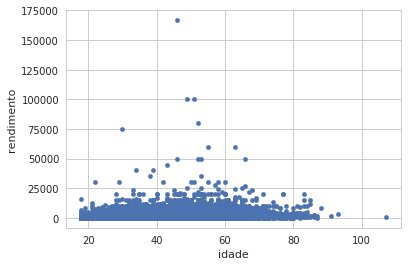

In [49]:
pnad.plot.scatter('idade', 'rendimento');

In [376]:
corr1 = pnad[['rendimento', 'idade', 'sexo', 'nivel_instrucao']].corr() # ocup_pos e sexo não fazem sentido
corr1

,rendimento,idade,sexo,nivel_instrucao
rendimento,1.000000,0.194560,-0.171942,0.049861
idade,0.194560,1.000000,0.014263,-0.131554
sexo,-0.171942,0.014263,1.000000,0.069157
nivel_instrucao,0.049861,-0.131554,0.069157,1.000000


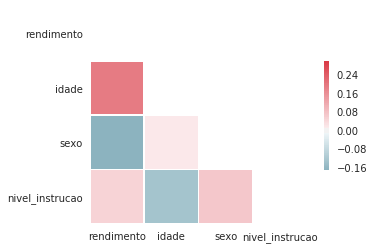

In [377]:
def plot_corr(corr):

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5});
    
plot_corr(corr1)

## Retirando os rendimentos altos.

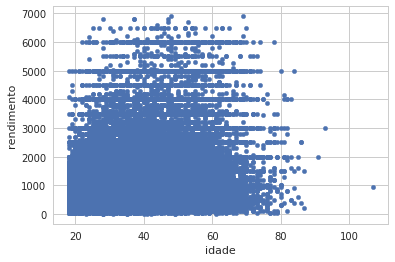

In [51]:
pnad.query('rendimento < 7000').plot.scatter('idade', 'rendimento');

In [380]:
corr2 = pnad[['rendimento', 'idade', 'sexo', 'nivel_instrucao']].query('rendimento < 7000').corr() # ocup_pos e sexo não fazem sentido
corr2

,rendimento,idade,sexo,nivel_instrucao
rendimento,1.000000,0.240873,-0.239728,0.073492
idade,0.240873,1.000000,0.020876,-0.135008
sexo,-0.239728,0.020876,1.000000,0.070726
nivel_instrucao,0.073492,-0.135008,0.070726,1.000000


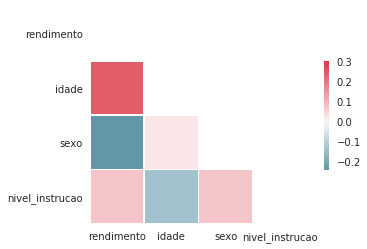

In [382]:
plot_corr(corr2)

## Incluindo pessoas sem rendimento

O intercepto aumentou no modelo 5 porque os coeficientes das três covariáveis diminuíram. 
Contralando essas variações, o resto continua o mesmo. 

In [280]:
637 - 490 # modelo4:  intercepto menos sexo

147

In [282]:
856 - 639 - 16 - 60 # modelo5: intercepto menos sexo, menos variação da idade e do nível de instrução

141

# Diagnósticos

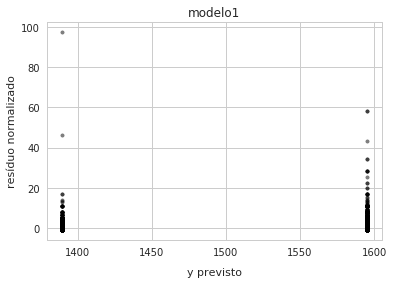

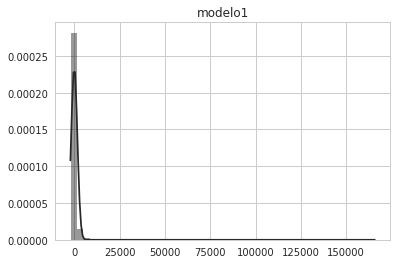

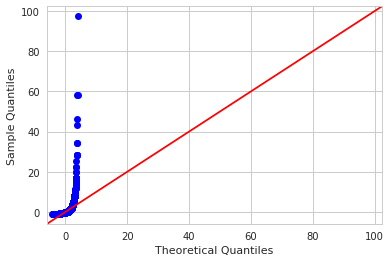

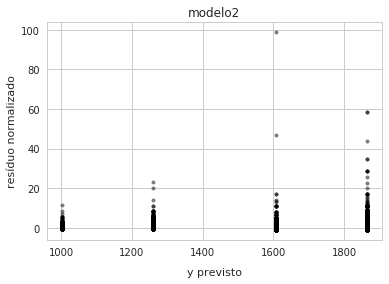

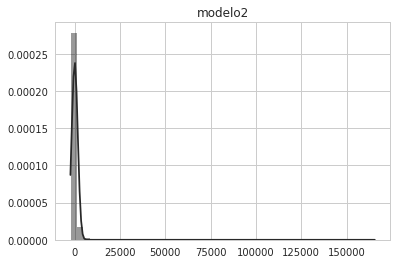

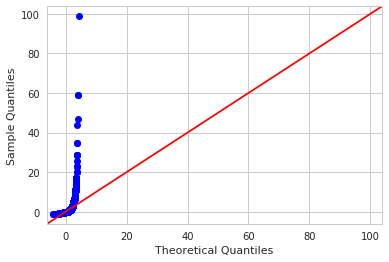

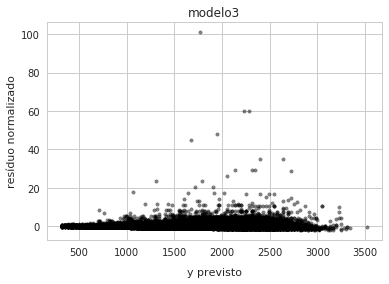

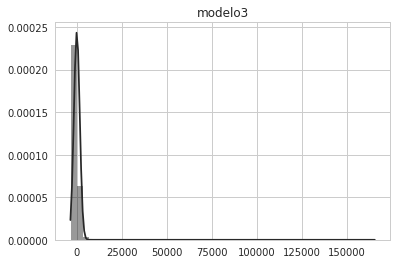

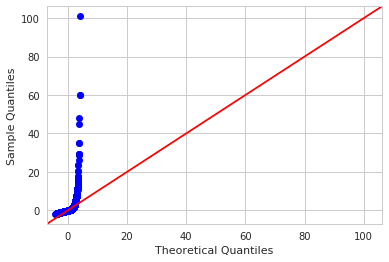

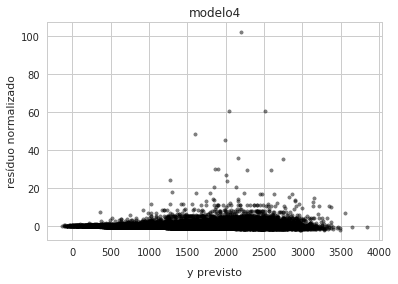

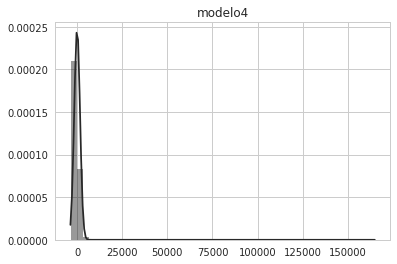

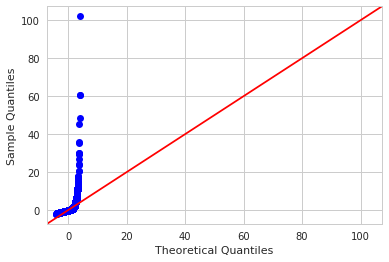

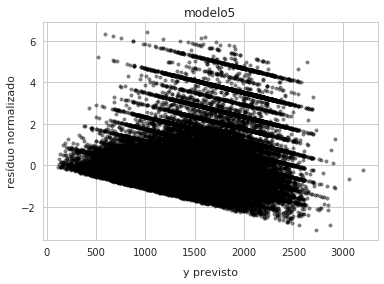

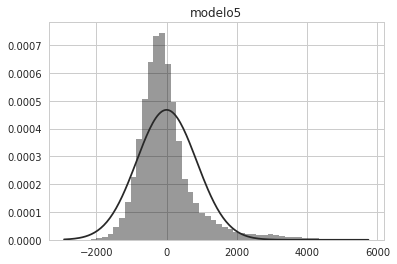

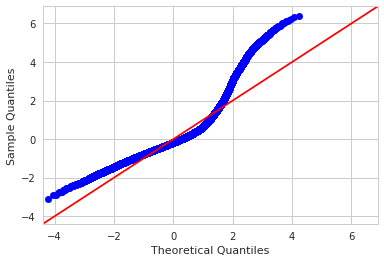

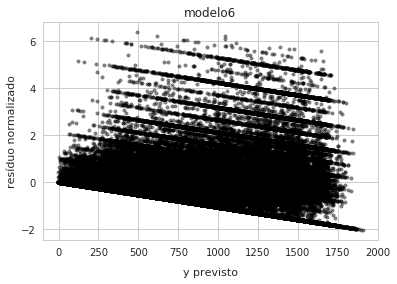

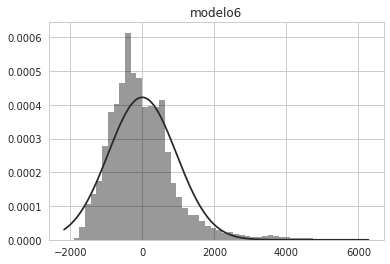

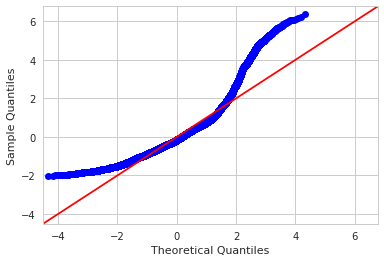

In [302]:
for i, j in zip(range(0, 6), range(0, 6)):
    plt.figure()
    plt.title(strings[j])
    plt.scatter(lista[i].predict(), lista[i].resid_pearson, marker='.', alpha=.5, color='black')
    plt.xlabel('y previsto', labelpad=10)
    plt.ylabel('resíduo normalizado')
    
    plt.figure()
    plt.title(strings[j])
    sns.distplot(lista[i].resid, kde=False, fit=stats.norm, color='black')
    
    fig, ax = plt.subplots()
    sms.qqplot(lista[i].resid_pearson, line='45', ax=ax, color=)

## Normalidade dos resíduos

In [291]:
for i, j in zip(range(0, 6), range(0, 6)):

    shapiro = stats.shapiro(lista[i].resid)
    jarque = sms.stats.jarque_bera(lista[i].resid)
    omnibus= sms.stats.omni_normtest(lista[i].resid)
    
    print('-------------------', '\n\n',
        strings[j], '\n\n',
          'média dos resíduos: ', int(lista[i].resid.mean()), '\n\n', 
          'teste de Jarque-Bera', '\n',
          'estatística: ', round(jarque[0], 2), ', valor-p: ', round(jarque[1], 2), '\n',
          'assimetria dos resíduos: ', round(jarque[2], 2), '\n',
          'kurtose dos resíduos: ', round(jarque[3], 2), '\n\n',
          'teste Omnibus', '\n',
          'estatística: ', round(omnibus[0], 2), ', valor-p: ', round(omnibus[1], 2), '\n\n' 
          'teste de Shapiro-Wilk', '\n'
          'estatística: ', round(shapiro[0], 2), ', valor-p: ', round(shapiro[1], 2), '\n\n')
    

------------------- 

 modelo1 

 média dos resíduos:  0 

 teste de Jarque-Bera 
 estatística:  8217877732.6 , valor-p:  0.0 
 assimetria dos resíduos:  23.25 
 kurtose dos resíduos:  1524.46 

 teste Omnibus 
 estatística:  201082.95 , valor-p:  0.0 

teste de Shapiro-Wilk 
estatística:  0.44 , valor-p:  0.0 


------------------- 

 modelo2 

 média dos resíduos:  0 

 teste de Jarque-Bera 
 estatística:  9171666585.72 , valor-p:  0.0 
 assimetria dos resíduos:  24.08 
 kurtose dos resíduos:  1610.36 

 teste Omnibus 
 estatística:  203932.28 , valor-p:  0.0 

teste de Shapiro-Wilk 
estatística:  0.45 , valor-p:  0.0 


------------------- 

 modelo3 

 média dos resíduos:  0 

 teste de Jarque-Bera 
 estatística:  10797987097.99 , valor-p:  0.0 
 assimetria dos resíduos:  25.28 
 kurtose dos resíduos:  1747.11 

 teste Omnibus 
 estatística:  207980.45 , valor-p:  0.0 

teste de Shapiro-Wilk 
estatística:  0.45 , valor-p:  0.0 


------------------- 

 modelo4 

 média dos resíduos

/home/lincoln/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<br>
<br>
<br>
## heterocedasticidade
<br>
<br>

In [7]:
for i, j in zip(range(0, 6), range(0, 6)):

    white = sms.stats.het_white(lista[i].resid, lista[i].model.exog)
    breusch = sms.stats.het_breuschpagan(lista[i].resid, lista[i].model.exog)
    
    print('---------------------', '\n\n',
       strings[j], '\n\n',
      'teste de white', '\n',
      'multiplicador de Lagrange: ', white[0].round(2), ', valor-p: ', white[1].round(2), '\n',      
      'teste-F: ', white[2].round(2), ', valor-p: ', white[3].round(2), '\n\n', 
      'teste breusch-pagan', '\n',
      'multiplicador de Lagrange: ', breusch[0].round(2), ', valor-p: ', breusch[1].round(2), '\n',      
      'teste-F: ', breusch[2].round(2), ', valor-p: ', breusch[3].round(2), '\n\n', )

--------------------- 

 modelo1 

 teste de white 
 multiplicador de Lagrange:  0.43 , valor-p:  0.51 
 teste-F:  0.43 , valor-p:  0.51 

 teste breusch-pagan 
 multiplicador de Lagrange:  0.43 , valor-p:  0.51 
 teste-F:  0.43 , valor-p:  0.51 


--------------------- 

 modelo2 

 teste de white 
 multiplicador de Lagrange:  17.67 , valor-p:  0.0 
 teste-F:  5.89 , valor-p:  0.0 

 teste breusch-pagan 
 multiplicador de Lagrange:  17.31 , valor-p:  0.0 
 teste-F:  8.66 , valor-p:  0.0 


--------------------- 

 modelo3 

 teste de white 
 multiplicador de Lagrange:  54.37 , valor-p:  0.0 
 teste-F:  7.77 , valor-p:  0.0 

 teste breusch-pagan 
 multiplicador de Lagrange:  43.56 , valor-p:  0.0 
 teste-F:  14.53 , valor-p:  0.0 


--------------------- 

 modelo4 

 teste de white 
 multiplicador de Lagrange:  387.59 , valor-p:  0.0 
 teste-F:  2.29 , valor-p:  0.0 

 teste breusch-pagan 
 multiplicador de Lagrange:  114.13 , valor-p:  0.0 
 teste-F:  3.57 , valor-p:  0.0 


-------

## Multicolinearidade

In [417]:
for i, j in zip(range(0, 6), range(0, 6)):

    variaveis = lista[i].model.exog
    vif = [variance_inflation_factor(variaveis, a) for a in range(variaveis.shape[1])]
    vif = np.array(vif)
    print('---------', '\n\n',
          strings[j], '\n', 
          'vif: ', round(np.array(vif).mean(), 2), '\n',
          'número condicional: ', round(np.linalg.cond(lista[i].model.exog), 2), '\n' )

--------- 

 modelo1 
 vif:  2.81 
 número condicional:  4.08 

--------- 

 modelo2 
 vif:  2.39 
 número condicional:  4.38 

--------- 

 modelo3 
 vif:  4.89 
 número condicional:  172.7 

--------- 

 modelo4 
 vif:  5.33 
 número condicional:  1670.64 

--------- 

 modelo5 
 vif:  5.32 
 número condicional:  1664.11 

--------- 

 modelo6 
 vif:  5.39 
 número condicional:  1782.83 



<br>
<br>
<br>
## Outliers e testes de influência
<br>
<br>

In [330]:
# outl = modelo5.outlier_test('fdr_bh') # demora
# outl.sort_values(by='unadj_p', inplace=True)

# from statsmodels.stats.outliers_influence import OLSInfluence
# test_class = OLSInfluence(modelo5)
# test_class.dfbetas()

# test_class.resid_std[:10]

In [356]:
# sms.graphics.influence_plot(modelo5)

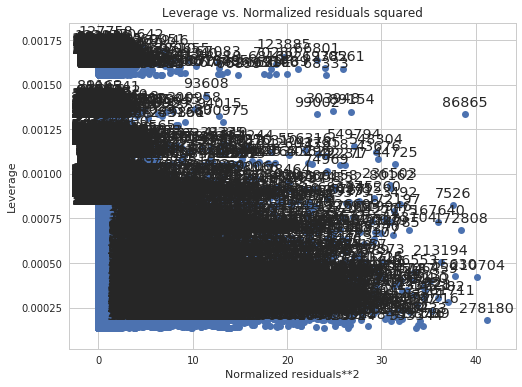

In [353]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sms.graphics.plot_leverage_resid2(modelo5, ax = ax)

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig = sms.graphics.plot_ccpr_grid(modelo, fig=fig)

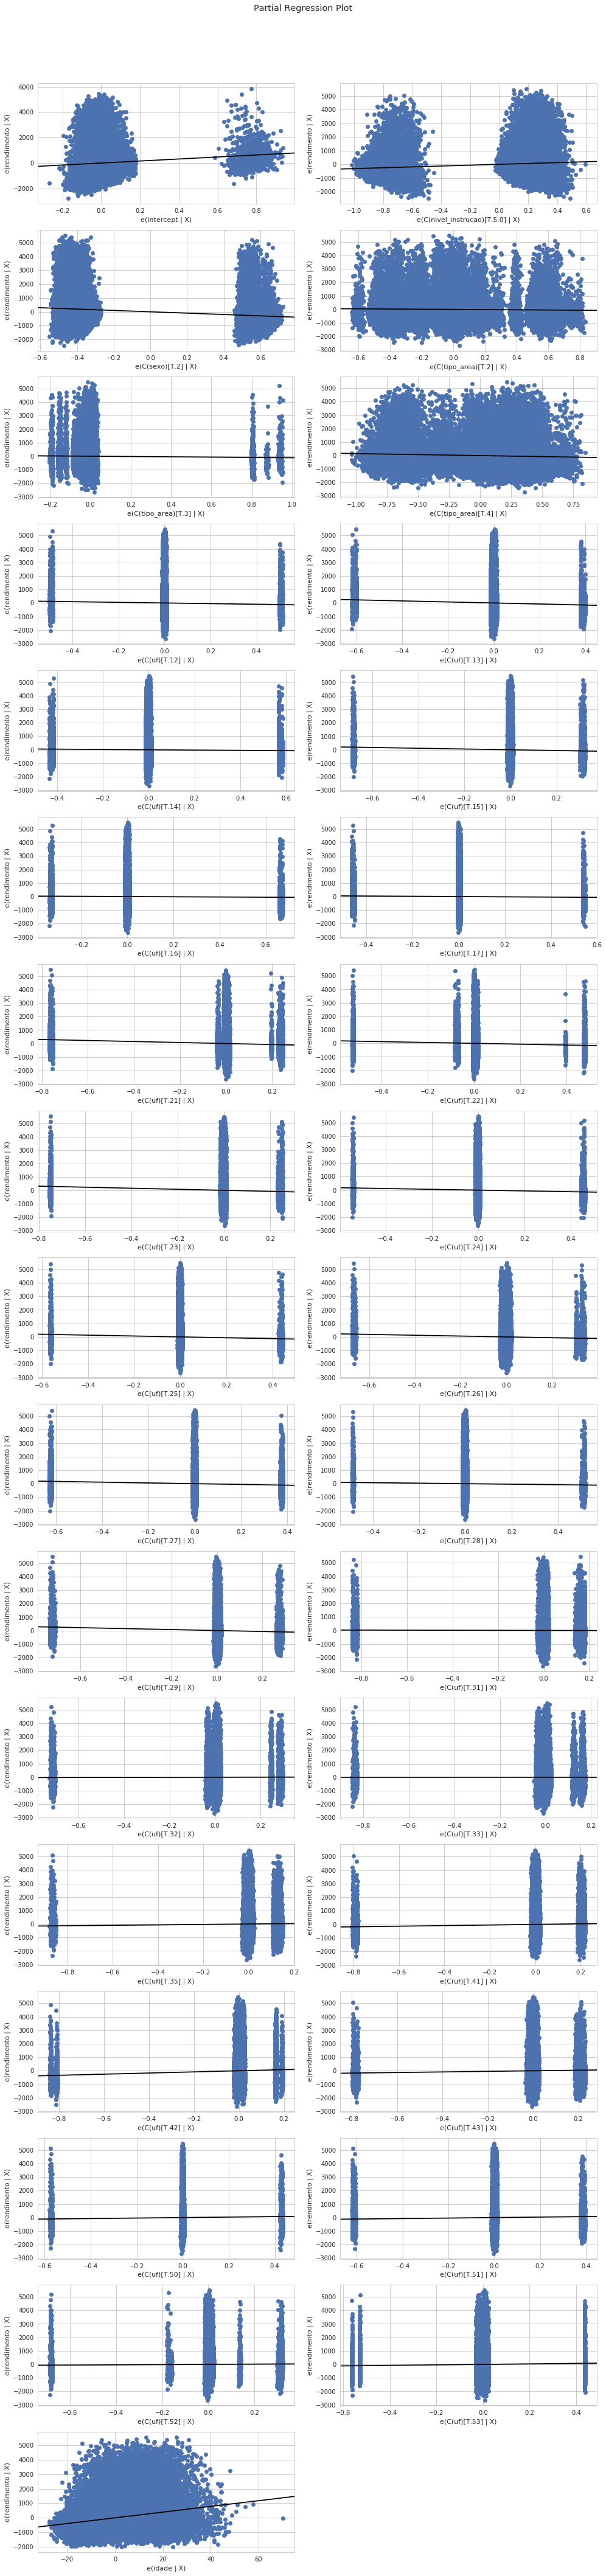

In [340]:
fig = plt.figure(figsize=(14,60))
fig = sms.graphics.plot_partregress_grid(modelo5, fig=fig)

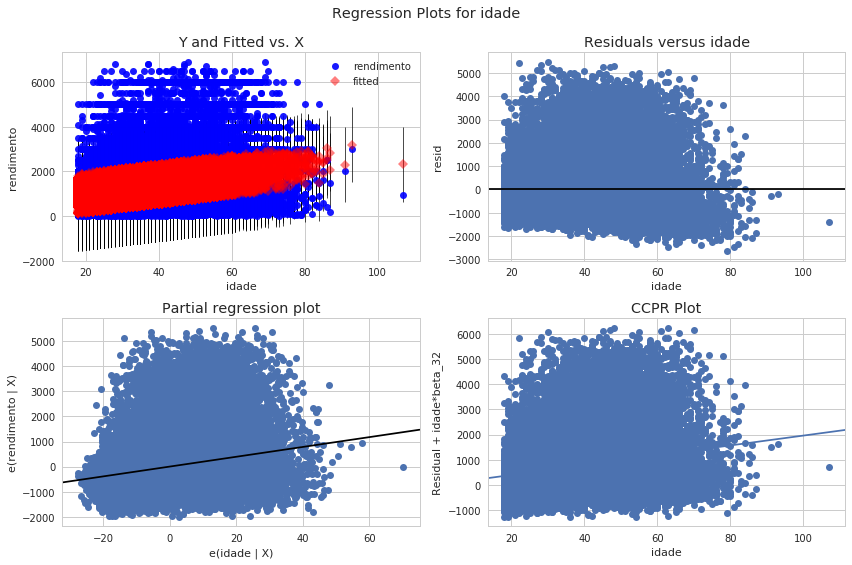

In [352]:
fig = plt.figure(figsize=(12,8))
fig = sms.graphics.plot_regress_exog(modelo5, 'idade', fig=fig)

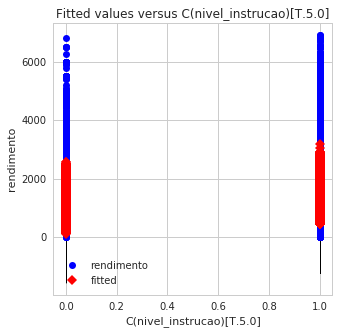

In [361]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sms.graphics.plot_fit(modelo5, 'C(nivel_instrucao)[T.5.0]', ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
fig = sms.graphics.plot_partregress(endog="renocup", exog_i="p_transf", exog_others=["p_transf", "p_agro"], data=atlas, ax=ax)

In [418]:
# fig, ax = plt.subplots(figsize=(15,20))
# fig = sms.graphics.plot_partregress_grid(modelo5, ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sms.graphics.plot_ccpr(modelo, "p_transf", ax=ax)

In [325]:
tabela.as_html()

'<table class="simpletable">\n<tr>\n              <td></td>              <th>Modelo 1</th> <th>Modelo 2</th> <th>Modelo 3</th> <th>Modelo 4</th> <th>Modelo 5</th> <th>Modelo 6</th>\n</tr>\n<tr>\n  <th>Intercept</th>                  <td>1389.44</td>  <td>1608.27</td>  <td>421.48</td>   <td>593.12</td>   <td>791.65</td>   <td>1022.69</td>\n</tr>\n<tr>\n  <th></th>                           <td>(12.49)</td>  <td>(12.99)</td>  <td>(22.75)</td>  <td>(50.28)</td>  <td>(26.81)</td>  <td>(23.09)</td>\n</tr>\n<tr>\n  <th>C(nivel_instrucao)[T.5.0]</th>  <td>205.56</td>   <td>255.81</td>   <td>370.55</td>   <td>390.54</td>   <td>313.08</td>   <td>247.93</td> \n</tr>\n<tr>\n  <th></th>                           <td>(14.11)</td>  <td>(13.93)</td>  <td>(13.74)</td>  <td>(13.64)</td>  <td>(7.27)</td>   <td>(6.11)</td> \n</tr>\n<tr>\n  <th>C(sexo)[T.2]</th>                  <td></td>      <td>-605.43</td>  <td>-622.28</td>  <td>-621.16</td>  <td>-491.00</td>  <td>-624.34</td>\n</tr>\n<tr>\n  <th></th